#  MLP Classifier for  SER (Speech Emotion Recognition)

Multilayer perceptrons (MLP) are often applied to supervised learning problems. They train on a set of input-output pairs and learn to model the correlation (or dependencies) between those inputs and outputs. The networkthus has a simple interpretation as a form of input-output model, with the weights and thresholds (biases) the free parameters of the model.

## Dataset

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS),and it is free to download. This dataset has 7356 files rated by 247 individuals 10 times on emotional validity, intensity, and genuineness. here the Speech files of all actors (01-24) will be used and the files are available under path ../datasets/RAVDESS. It contains 1440 files: 60 trials per actor x 24 actors = 1440. 
Filename identifiers:
<ol>
<li>Modality (01 = full-AV, 02 = video-only, 03 = audio-only).</li>
<li>Vocal channel (01 = speech, 02 = song).</li>
<li>Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).</li>
<li>Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.</li>
<li>Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").</li>
<li>Repetition (01 = 1st repetition, 02 = 2nd repetition)..</li>
<li>Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).</li>
</ol>

## Downloading Libraries

In [1]:
#!pip install librosa soundfile numpy sklearn pyaudio

In [2]:
#!pip install soundfile

## Libraries Import

In [3]:
# Import our libraries
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import os, glob, pickle
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import soundfile
import seaborn as sn
import pandas as pd

## Feature Extraction

Defining a function extract_feature to extract the mfcc, chroma, and mel features from a sound file. This function takes 4 parameters- the file name and three Boolean parameters for the three features:
file.
<ol>
<li>file: for the given file name with the path</li>
<li>mfcc: Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound</li>
<li>chroma: Pertains to the 12 different pitch classes</li>
<li>mel: Mel Spectrogram Frequency</li>
</ol>




In [4]:
#Extract features (mfcc, chroma, mel) from a given sound file(with path)
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [5]:
#Emotions in the RAVDESS dataset, it will not take the neutral into the modeling process
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fear',
  '07':'disgust',
  '08':'surprise'
}
#Emotions to observe(all emotions except neutral)
observed_emotions=['calm', 'happy', 'sad','angry','fear', 'disgust','surprise']

## Retrieve RAVDESS dataset from File System

In [6]:
#audio file path in file system
RAV = "../datasets/RAVDESS/"
# test to run one example 
dir_list = os.listdir(RAV+"Actor_01/")
dir_list[0:5]

['03-01-01-01-01-01-01.wav',
 '03-01-01-01-01-02-01.wav',
 '03-01-01-01-02-01-01.wav',
 '03-01-01-01-02-02-01.wav',
 '03-01-02-01-01-01-01.wav']

In [7]:
#Load the data and extract features for each sound file
def load_data(test_size=0.25):
    x,y=[],[]
    for file in glob.glob(RAV+"Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, train_size= 0.75,random_state=9)

In [8]:
#Split the dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.25)

In [9]:
#Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

(1008, 336)


In [10]:
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


## MLP Classifier and Fit/Train the Model

In [11]:
#Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [12]:
#Fit/Train the model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

## Predict the accuracy and result

In [13]:
#Predict for the test set
y_pred=model.predict(x_test)

Accuracy: 58.33%
Statistics:
              precision    recall  f1-score   support

       angry       0.71      0.78      0.74        50
        calm       0.57      0.84      0.68        57
     disgust       0.80      0.35      0.48        46
        fear       0.72      0.51      0.60        57
       happy       0.37      0.61      0.46        38
         sad       0.41      0.35      0.38        43
    surprise       0.70      0.58      0.63        45

    accuracy                           0.58       336
   macro avg       0.61      0.57      0.57       336
weighted avg       0.62      0.58      0.58       336

Confusion Matrix:


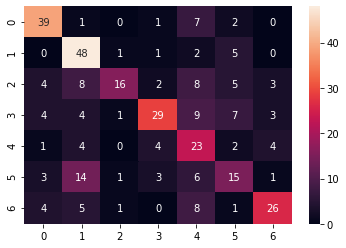

In [14]:
#Calculate the accuracy of the model

accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
matrix = confusion_matrix(y_test,y_pred)
#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

#Print the report
print("Statistics:")
print(classification_report(y_test,y_pred))

#Print the Confusion Matrix
print("Confusion Matrix:")
df_cm = pd.DataFrame(matrix)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()